## Numeryczne Rozwiązywanie Rónań Różniczkowych Cząstkowych
### Uniwersytet Jagielloński 2021
Katedra Teorii Optymalizacji i Sterowania UJ

# Metoda różnic skończonych

## Laboratorium III
### Równanie hiperboliczne

$$ u_{tt} = u_{xx} \,\,\,\,\,\, x \in (0, 1), \,\,\,\, t > 0 $$

$$ u(t, 0) = u(t, 1) = 0 \,\,\,\,\,\, t>0 $$

$$ u(0, x) = \frac{1}{8}\sin(\pi x) \,\,\,\,\,\, x \in [0, 1] $$

$$ u_{t}(0, x) = 0 \,\,\,\,\,\, x \in [0, 1] $$

Rozwiązanie dokładne: $$ u(t, x) = \frac{1}{8}\sin(\pi x)\cos(\pi t) $$

In [ ]:
import numpy as np
import scipy as sc
import scipy.sparse.linalg
from mpl_toolkits.mplot3d import Axes3D

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt


from matplotlib import cm

from matplotlib.ticker import LinearLocator, FormatStrFormatter
from scipy.sparse import lil_matrix, csr_matrix
from typing import Optional
import time

In [ ]:
class SetupHyperbolic:
    def __init__(self, 
                 dx: float, 
                 dt: Optional[float] = None,
                 output_freq: Optional[int] = 10,
                 alpha: float = 0.5
                 ):
        self.x_range = (0.0, 1.0)
        self.t_range = (0.0, 2.0)
        self.boundary_condition = (lambda t: 0.0, lambda t: 0.0)

        self.alpha = alpha 
        dt = dt or dx
        # There are 2 hard problems in computer science:
        # cache invalidation, naming things, and off-by-1 errors.
        self.x_num = round((self.x_range[1] - self.x_range[0]) / dx) + 1
        self.t_num = round((self.t_range[1] - self.t_range[0]) / dt) + 1

        self.X, self.dx = np.linspace(*self.x_range, self.x_num, retstep=True)
        self.T, self.dt = np.linspace(*self.t_range, self.t_num, retstep=True)

        self.output_freq = output_freq

    @staticmethod
    def initial(x):
        return 0.125 * np.sin(np.pi * x)

    @staticmethod
    def initial_der(x):
        return 0

    @staticmethod
    def exact(t, x):
        return 0.125 * np.sin(np.pi * x) * np.cos(np.pi * t)

In [ ]:
def plot_surface(u, setup):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    T = np.linspace(*setup.t_range, setup.t_num // setup.output_freq)
    X = np.linspace(*setup.x_range, setup.x_num)
    T, X = np.meshgrid(T, X)
    surf = ax.plot_surface(T, X, u, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)

    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

In [ ]:
import scipy.sparse.linalg
from scipy.sparse import dia_matrix, identity
def Lh(setup):
    n = setup.x_num-2
    diag = np.ones(n)
    return (1/setup.dx**2)*dia_matrix(([diag, -2*diag, diag], [-1,0,1]), shape=(n,n))    

def scheme_hyperbolic(setup):
    u_matrix = np.zeros((setup.x_num, setup.t_num // setup.output_freq))

    T = np.linspace(*setup.t_range, setup.t_num // setup.output_freq)
    u_matrix[:,0] = setup.initial(setup.X)
    u_matrix[0,:] = [setup.boundary_condition[0](t) for t in T]
    u_matrix[-1,:] = [setup.boundary_condition[1](t) for t in T]

    L = Lh(setup)
    if setup.alpha == 0:
        A = (setup.dt**2)*L + 2*identity(setup.x_num-2)
    else:
        A = sc.sparse.linalg.inv(((1/setup.dt**2)*identity(setup.x_num-2) - setup.alpha*L).tocsc())*L +2*identity(setup.x_num-2)
        
    u0 = u_matrix[1:-1,0]
    u1 = 0.5*A*u0 + setup.dt*setup.initial_der(setup.X[1:-1])
    if setup.output_freq == 1: u_matrix[1:-1,1] = u1
    for t in range(2, (setup.t_num // setup.output_freq) * setup.output_freq):
        u2 = A*u1 - u0
        if t % setup.output_freq == 0:
            u_matrix[1:-1, t // setup.output_freq] = u2
        u0 = u1
        u1 = u2
    return u_matrix

In [ ]:
%%time
# numerical solution
setup_hyperbolic = SetupHyperbolic(dx=0.01, dt=0.001)
numerical_hyperbolic = scheme_hyperbolic(setup_hyperbolic)

CPU times: user 66.6 ms, sys: 446 µs, total: 67 ms
Wall time: 68.5 ms


In [ ]:
# exact solution
X = np.linspace(*setup_hyperbolic.x_range, setup_hyperbolic.x_num)
T = np.linspace(*setup_hyperbolic.t_range, setup_hyperbolic.t_num // setup_hyperbolic.output_freq)
X, T = np.meshgrid(X, T)
exact_hyperbolic = setup_hyperbolic.exact(T, X).T

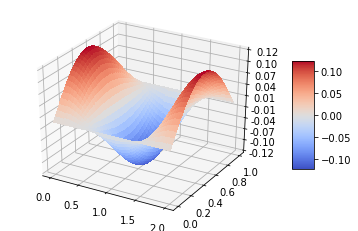

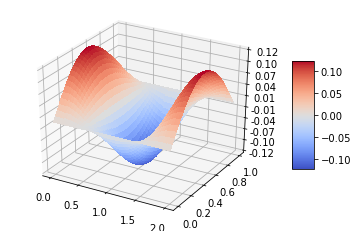

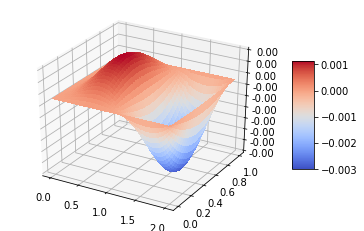

In [ ]:
plot_surface(numerical_hyperbolic, setup_hyperbolic)
plot_surface(exact_hyperbolic, setup_hyperbolic)
plot_surface(numerical_hyperbolic - exact_hyperbolic, setup_hyperbolic)


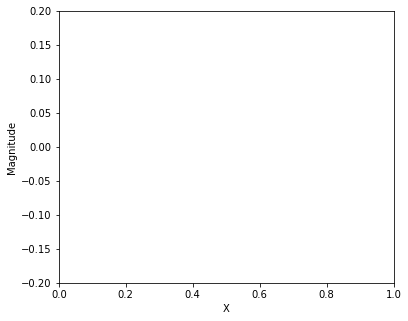

In [ ]:
#%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# create a figure and axes
fig = plt.figure(figsize=(6,5))
ax1 = plt.subplot(1,1,1)   
# ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
ax1.set_xlim(setup_hyperbolic.x_range)            
ax1.set_ylim((-0.2, 0.2))
ax1.set_xlabel('X')
ax1.set_ylabel('Magnitude')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('')
line1, = ax1.plot([], [], 'orange', lw=2)     # ax.plot returns a list of 2D line objects

In [ ]:
# animation function. This is called sequentially
def drawframe(n):
    x = setup_hyperbolic.X
    y = numerical_hyperbolic[:, n]
    line1.set_data(x, y)
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (line1,)

In [ ]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
interval=setup_hyperbolic.t_range[1] * 1000 // numerical_hyperbolic.shape[1]
anim = animation.FuncAnimation(fig, drawframe, frames=numerical_hyperbolic.shape[1], interval=interval, blit=True)

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())